# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [1]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


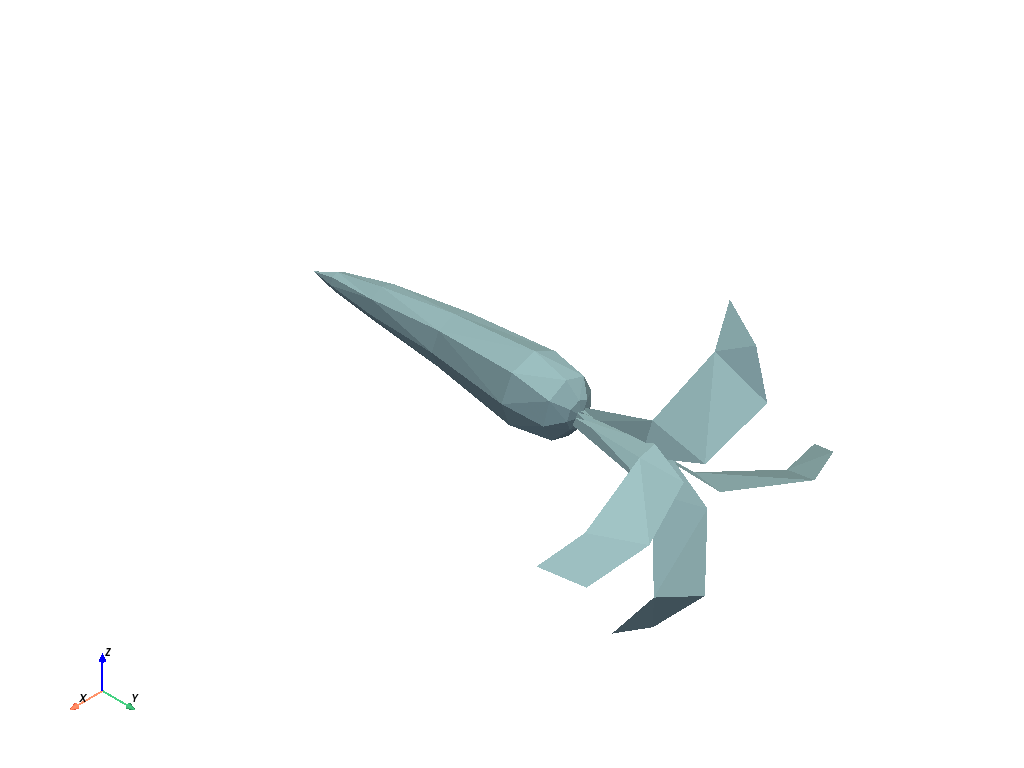

In [3]:
#load object

sphere_path = "objects/sphere.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"
crawler = "objects/crawler.obj" # warning - large file!!


file_path = carrot

path = Path(file_path).resolve()
mesh = pv.read(path)
mesh.plot()


In [4]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[-2.897315, 13.289683,  3.413437],
       [-2.012119, 13.614882,  2.388781],
       [-2.604325, 14.434612,  2.676664],
       ...,
       [-0.70618 , 14.267506, -0.430716],
       [-2.714794, 16.596111, -0.506234],
       [-3.16743 , 15.475259, -1.047851]], dtype=float32)

In [5]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [6]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [7]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

len(objects)

152

In [8]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([-0.040499210357666016, 8.306123648770154, -0.29418349266052246],
 -9.933327198028564)

In [9]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([ -0.04049921,   8.30612365, -10.22751069]), array([0., 0., 1.]))

In [10]:
# Setup scene

# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [11]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = numba.typed.List()
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(152, 152)

In [12]:
from accelerators.hlbvh_njit import build_hlbvh
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)

# ordered_prims = numba.typed.List()
# ordered_prims.append(objects[0]) # just for numba
# ordered_prims.pop(0)

ordered_prims = objects

total_nodes = numba.typed.List()
total_nodes.append(0)

split_method = 0 # 0: surface area heuristics, 1: mid-point, 2: equal parts

start_t = time.time()
# root = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes, split_method)
root = build_hlbvh(objects, bounded_boxes, ordered_prims, total_nodes)


end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 5.5470709800720215


In [13]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree (empty)

start_t = time.time()
linear_bvh = numba.typed.List()
for _ in range(total_nodes[0]):
    linear_bvh.append(LinearBVHNode())

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.20981502532958984


In [14]:
from accelerators.bvh import flatten_bvh

# add nodes to the empty linear tree
_offset = flatten_bvh(linear_bvh, root, [0])
len(linear_bvh), _offset

(215, 0)

In [15]:
# # ** render function without progress bar **
#
# from scenes.render import _render_scene
#
# start_t = time.time()
# # primitives = spheres, triangles
# image = _render_scene(scene, objects, linear_bvh)
# end_t = time.time()
# print("Elapsed (with compilation) = %s" % (end_t - start_t))

In [16]:
from numba_progress import ProgressBar

num_iterations = scene.height

start_t = time.time()

with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
    image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)


Elapsed (with compilation) = 1.757584810256958


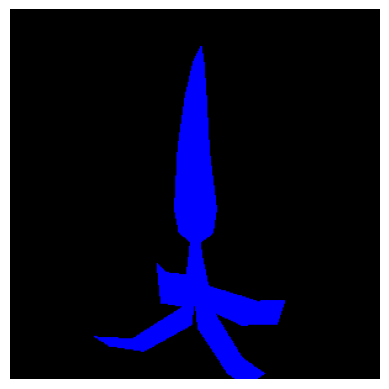

In [17]:
plt.imshow(image)
plt.axis('off')
plt.show()